Training DataLoader created successfully with batch size: 64
Testing DataLoader created successfully with batch size: 64
Feature map shape before FC: torch.Size([2, 64, 56, 56])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 56, 56]          --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─ReLU: 2-2                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-4                       [-1, 64, 112, 112]        18,496
|    └─ReLU: 2-5                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-6                    [-1, 64, 56, 56]          --
├─Sequential: 1-2                        [-1, 70]                  --
|    └─Flatten: 2-7                      [-1, 200704]              --
|    └─Linear: 2-8                       [-1, 256]                 51,380,480
|    └─ReLU: 2-9                  

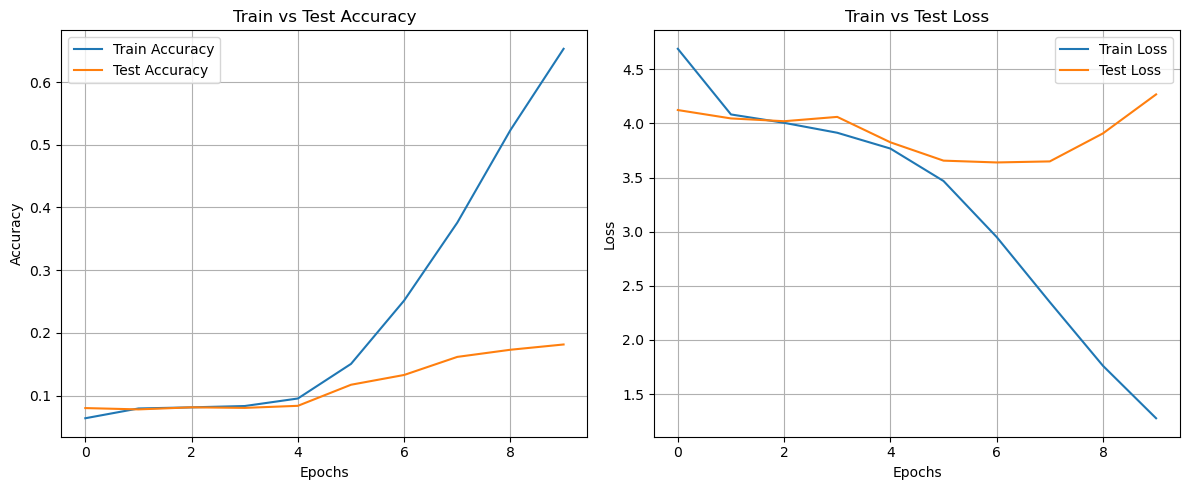

In [5]:
import os
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image
import multiprocessing
import matplotlib.pyplot as plt
from torchsummary import summary

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the folder containing the images
image_folder = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images'

# Paths to the text files
train_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_family_train.txt'
test_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_family_test.txt'

# Define label mapping
label_mapping = {
    "Boeing 707": 0,
    "Boeing 727": 1,
    "Boeing 737": 2,
    "Boeing 747": 3,
    "Boeing 757": 4,
    "Boeing 767": 5,
    "Boeing 777": 6,
    "A300": 7,
    "A310": 8,
    "A320": 9,
    "A330": 10,
    "A340": 11,
    "A380": 12,
    "ATR-42": 13,
    "ATR-72": 14,
    "An-12": 15,
    "BAE 146": 16,
    "BAE-125": 17,
    "Beechcraft 1900": 18,
    "Boeing 717": 19,
    "C-130": 20,
    "C-47": 21,
    "CRJ-200": 22,
    "CRJ-700": 23,
    "Cessna 172": 24,
    "Cessna 208": 25,
    "Cessna Citation": 26,
    "Challenger 600": 27,
    "DC-10": 28,
    "DC-3": 29,
    "DC-6": 30,
    "DC-8": 31,
    "DC-9": 32,
    "DH-82": 33,
    "DHC-1": 34,
    "DHC-6": 35,
    "Dash 8": 36,
    "DR-400": 37,
    "Dornier 328": 38,
    "Embraer E-Jet": 39,
    "EMB-120": 40,
    "Embraer ERJ 145": 41,
    "Embraer Legacy 600": 42,
    "Eurofighter Typhoon": 43,
    "F-16": 44,
    "F/A-18": 45,
    "Falcon 2000": 46,
    "Falcon 900": 47,
    "Fokker 100": 48,
    "Fokker 50": 49,
    "Fokker 70": 50,
    "Global Express": 51,
    "Gulfstream": 52,
    "Hawk T1": 53,
    "Il-76": 54,
    "L-1011": 55,
    "MD-11": 56,
    "MD-80": 57,
    "MD-90": 58,
    "Metroliner": 59,
    "King Air": 60,
    "PA-28": 61,
    "SR-20": 62,
    "Saab 2000": 63,
    "Saab 340": 64,
    "Spitfire": 65,
    "Tornado": 66,
    "Tu-134": 67,
    "Tu-154": 68,
    "Yak-42": 69
}

# Define transformations for image processing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor()          # Convert to tensor
])

def process_data(label_file):
    image_data = []
    labels = []

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) != 2:
                continue  # Skip malformed lines
            filename, label = parts
            image_path = os.path.join(image_folder, filename + ".jpg")

            try:
                if os.path.exists(image_path) and label in label_mapping:
                    image = Image.open(image_path).convert("RGB")
                    image_tensor = transform(image)
                    image_data.append(image_tensor)

                    # Map label string to integer using label_mapping
                    label_int = label_mapping[label]
                    labels.append(label_int)
                else:
                    print(f"Warning: Label '{label}' not found in label_mapping or image missing.")
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    # Ensure consistent data sizes
    assert len(image_data) == len(labels), "Mismatch between image data and labels."

    # Convert lists to PyTorch tensors
    try:
        image_tensor = torch.stack(image_data)  # Stack image data into a single tensor
        label_tensor = torch.tensor(labels, dtype=torch.long)  # Ensure labels are integer tensors
    except Exception as e:
        raise RuntimeError(f"Error during tensor conversion: {e}")

    return image_tensor, label_tensor

# Process training data
train_image_tensor, train_label_tensor = process_data(train_label_file)

# Create training TensorDataset
train_dataset = TensorDataset(train_image_tensor, train_label_tensor)

# Example usage of DataLoader
batch_size = 64
num_workers = multiprocessing.cpu_count()
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
print("Training DataLoader created successfully with batch size:", batch_size)

# Process testing data
test_image_tensor, test_label_tensor = process_data(test_label_file)

# Create testing TensorDataset
test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

# Example usage of DataLoader for testing data
test_loader = DataLoader(test_dataset, batch_size, num_workers=num_workers, pin_memory=True)
print("Testing DataLoader created successfully with batch size:", batch_size)

# Define a simple CNN model
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 256),  # Adjust for 224x224 input
            nn.ReLU(),
            nn.Linear(256, 70)  # Output matches number of classes
        )

    def forward(self, x):
        x = self.conv_layer(x)
        print(f"Feature map shape before FC: {x.shape}")  # Debugging
        x = self.fc_layer(x)
        return x

# Define evaluation function
def evaluate(model, data_loader):
    model.eval()
    total, correct, total_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs  # Free memory
            torch.cuda.empty_cache()
    return correct / total, total_loss / len(data_loader)

# Initialize the model, loss function, and optimizer
model = CNNNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, test_loader, epochs, patience=5):
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': []
    }
    min_test_loss = float('inf')
    early_stop_count = 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        test_acc, test_loss = evaluate(model, test_loader)

        history['train_loss'].append(train_loss / len(train_loader))
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, "
              f"Test Acc: {test_acc:.4f}")

        # Early stopping
        if test_loss < min_test_loss:
            min_test_loss = test_loss
            early_stop_count = 0
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                print("Early stopping triggered!")
                break

    return history

# Summarize the model
print(summary(model, (3, 224, 224)))

# Train the model
history = train_model(model, train_loader, test_loader, epochs=10)

# Plot the training and test accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.grid(True)
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
